## Concrete traces classification

*Author:* Alexandre Romagnolli Gonçalves

*Date:* June 1, 2023

*Abstract:* The dosage of materials is a vital factor in constructing safe civil structures and maintaining public safety. In particular, the properties of final samples, in both fresh and hardened states, are significantly influenced by the characteristics and mix proportion of materials used in concrete traces. Traditionally, the identification of concrete traces has been a manual process carried out by human experts, which can be subject to physical and subjective influences. Furthermore, researchers often find it challenging to access representative, reliable, and consistent databases. Therefore, the development of an automated system to identify concrete traces is a promising research direction. In this context, this study addresses these issues by introducing a unique database composed of images from two distinct classes of concrete traces; specificaly, our goal is to implement image preprocessing techniques on a concrete traces dataset for data augementation, to train different achitectures for classifying these images into two (binary) classes, and to evaluate the performance of the obtained models. Concerning the architectures of the DNNs, we considered 

1. **Proposed Model:** A custom model built for high accuracy, comprising several Conv2D, BatchNormalization, MaxPooling2D, and Dense layers, along with Dropout for regularization.

2. **InceptionV3 (Transfer Learning):** This model employs the pre-trained InceptionV3 as a base, retaining its learned weights while adding extra Flatten and Dense layers for task-specific learning.

3. **VGG16 (Transfer Learning):** This model utilizes the pre-trained VGG16 as its base, with added Flatten and Dense layers.

Upon evaluating the models' performance, we found that the "Proposed model" achieved the highest F1-score at 93.22%, reflecting a robust balance of precision and recall, and demonstrating its superior performance in classifying the cement images; on the other hand, the transfer learning models, derived from the "InceptionV3" and "VGG16", achieved lower F1-scores at 82.97% and 80.31% respectively, indicating that they were less effective for this specific classification task.

### Loading libraries and preparing the environment

In [1]:
# !pip install wget
# !pip install split-folders
# !pip install opencv-python
# !pip install pillow

In [2]:
# Standard Library Imports
import os
import time
import warnings
import shutil

# Third-Party Imports
import cv2
import wget
import zipfile
import numpy as np
import pandas as pd
from PIL import Image, ImageFile
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import splitfolders

# TensorFlow and Keras Libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, CSVLogger, ModelCheckpoint
from tensorflow.keras.models import load_model
import tensorflow.keras.backend as K

# Set Matplotlib to Inline
%matplotlib inline

# Ignore UserWarnings from TiffImagePlugin
warnings.filterwarnings('ignore', category=UserWarning, module='PIL')
# Ignore UserWarnings from Keras
warnings.filterwarnings('ignore', category=UserWarning, module='keras')

In [3]:
# TensorFlow
print(f'TensorFlow version: {tf.__version__}')

# Pillow
import PIL
print(f'Pillow version: {PIL.__version__}')

# NumPy
print(f'NumPy version: {np.__version__}')

# Pandas
print(f'Pandas version: {pd.__version__}')

# Matplotlib
import matplotlib
print(f'Matplotlib version: {matplotlib.__version__}')

# Scikit-learn
import sklearn
print(f'Scikit-learn version: {sklearn.__version__}')

TensorFlow version: 2.13.0
Pillow version: 10.0.0
NumPy version: 1.25.0
Pandas version: 1.5.3
Matplotlib version: 3.7.2
Scikit-learn version: 1.2.2


In [4]:
print(f'{"="*80}')
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(f'Physical GPUs: {len(gpus)}, Logical GPUs: {len(logical_gpus)}')
        
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
else:
    print('No GPUs found')
print(f'{"="*80}')

Physical GPUs: 1, Logical GPUs: 1


#### Downloading data and preprocessing the dataset

In [7]:
def prepare_image_data(input_folder, output_folder, img_size=(256, 256)):
    """
    Cuts and rotates the images in the input folder and saves each rotation as a new image in the output folder.
    
    Args:
    input_folder (str): The directory path of the input images.
    output_folder (str): The directory path where the output images will be saved.
    img_size (tuple): The size (height, width) to which to resize the images.
    """
    hf, wf = img_size[0], img_size[1]
    angle = 10
    rot_angle = 0
    color_to_remove = (0, 0, 0)
    
    # Generating fragments for the original image
    print(f'Applying data augmentation to {input_folder}')

    for img_name in os.listdir(input_folder):
        img_path = os.path.join(input_folder, img_name)
        img = cv2.imread(img_path)
        
        # Aplying data augmentation
        while rot_angle < 360:
            ho, wo = img.shape[0], img.shape[1]
            rows, cols = img.shape[:2]
            M = cv2.getRotationMatrix2D((cols / 2, rows / 2), rot_angle, 1)
            rotated_img = cv2.warpAffine(img, M, (cols, rows))

            # Split into fragments of img_size
            for i in range(ho//hf):
                for j in range(wo//wf):
                    fragment = rotated_img[i*hf:(i+1)*hf, j*wf:(j+1)*wf, :]
                    fragment_name = f'{img_name[:-4]}_frag_{i}_rot_{rot_angle}.jpg'
                    fragment_path = os.path.join(output_folder, fragment_name)
                    cv2.imwrite(fragment_path, fragment)
                    
                    # If the fragment was saved
                    if os.path.isfile(fragment_path):
                        try:
                            # Open the image using PIL
                            image = Image.open(fragment_path)
                            pixels = image.load()
                            width, height = image.size
                            
                            # Iterate over the pixels of the image
                            for x in range(width):
                                for y in range(height):
                                    # If a pixel is the color to remove, delete the fragment
                                    if pixels[x, y] == color_to_remove:
                                        os.remove(fragment_path)
                                        # Exit the loops early as we've deleted the image
                                        break
                                # Break the outer loop if the image was deleted
                                if not os.path.isfile(fragment_path):
                                    break
                        except:
                            pass
            rot_angle += angle
        rot_angle = 0
        
        # Remove the original image
        os.remove(img_path)

    print(f'Original images have been deleted after applying data augementation to {input_folder}.')
        
    return None

def dataset_cleanup(dir):
    """
    Cleans up the dataset by removing empty or invalid images.
    
    Args:
    dir (str): The directory path to clean.
    """
    
    print(f'Running cleanup in directory: {dir}')

    # Traverse all subdirectories and files
    for currentpath, _, files in os.walk(dir):
        for file in files:
            img_path = os.path.join(currentpath, file)

            try:
                # Check if the file is empty
                if os.stat(img_path).st_size == 0:
                    os.remove(img_path)
                    print(f'Empty file: {file} (DELETED)')
                    continue
                # Verify the image using PIL
                ImageFile.LOAD_TRUNCATED_IMAGES = False
                img = Image.open(img_path)
                img.verify()

                # Verify the image using TensorFlow
                img = tf.io.read_file(img_path)
                img = tf.image.decode_image(img)

                # Check if the image is not None and has the correct dimensions
                if img is None or img.shape[2] != 3:
                    os.remove(img_path)
                    print(f'Dimension error: {file} (DELETED)')
                    continue
            except:
                print(f'Error reading file: {file} (DELETED)')
                os.remove(img_path)
    return None

def rename_files(dataset_dir, subdir):
    """
    This function renames files in a sequential order in a specified directory.

    Parameters:
    dataset_dir (str): The directory where the files are located.
    subdir (str): The subdirectory to consider for renaming.

    Returns:
    None
    """
    
    print(f'Renaming files in {os.path.join(dataset_dir, subdir)}')

    # Initialize a counter for the filenames
    count = 0

    # Get the list of all files in the directory
    file_list = os.listdir(os.path.join(dataset_dir, subdir))

    # Iterate over each file in the directory
    for filename in file_list:

        # Define the old file path
        old_file_path = os.path.join(dataset_dir, subdir, filename)

        # Define the new filename using the provided pattern
        new_filename = f'{subdir}_{str(count).zfill(4)}.jpg'

        # Define the new file path
        new_file_path = os.path.join(dataset_dir, subdir, new_filename)

        # Rename the file
        shutil.move(old_file_path, new_file_path)

        # Increment the counter
        count += 1

    print(f'Number of files {count} in the directory {os.path.join(dataset_dir, subdir)}')
    
    return None


In [8]:
# URLs and directory path
url = 'http://lapse.td.utfpr.edu.br/downloads/recortes_cimento_prof_jefferson.zip'
dataset_dir = './dataset/'

# Download the dataset
if not os.path.exists('dataset.zip'):
    wget.download(url, 'dataset.zip')
    print(f'{"="*80}')
    print('Download complete!')

# Unzip the file into the dataset directory
with zipfile.ZipFile('dataset.zip', 'r') as zip_ref:
    zip_ref.extractall(dataset_dir)

# Move the relevant files to the T1 and T2 directories
shutil.move(os.path.join(dataset_dir, '02 Imagens - Recortes/001 - T2'), os.path.join(dataset_dir, 'T2'))
shutil.move(os.path.join(dataset_dir, '02 Imagens - Recortes/002 - T1'), os.path.join(dataset_dir, 'T1'))
shutil.rmtree(os.path.join(dataset_dir, '02 Imagens - Recortes'))

# Prepare images and cleanup
for subdir in ['T1', 'T2']:
    subdir_path = os.path.join(dataset_dir, subdir)
    
    print(f'{"="*80}')
    # Prepare images in-place
    prepare_image_data(subdir_path, subdir_path)
    
    # Cleanup in-place
    dataset_cleanup(subdir_path)

    # Rename files to match the expected format
    rename_files(dataset_dir, subdir)

# Separate the images into training, testing, and validation folders
print(f'{"="*80}')
print(f'Splitting the dataset into training, testing, and validation folders...')
splitfolders.ratio(input=dataset_dir, output=dataset_dir, seed=42, ratio=(.7, .1, .2))
print(f'{"="*80}')

# Delete the zip file
print(f'Removing unnecessary files and folders...')
os.remove('dataset.zip')
shutil.rmtree(os.path.join(dataset_dir, 'T1'))
shutil.rmtree(os.path.join(dataset_dir, 'T2'))
print(f'{"="*80}')

Download complete!
Applying data augmentation to ./dataset/T1
Original images have been deleted after applying data augementation to ./dataset/T1.
Running cleanup in directory: ./dataset/T1
Renaming files in ./dataset/T1
Number of files 4993 in the directory ./dataset/T1
Applying data augmentation to ./dataset/T2
Original images have been deleted after applying data augementation to ./dataset/T2.
Running cleanup in directory: ./dataset/T2
Renaming files in ./dataset/T2
Number of files 7125 in the directory ./dataset/T2
Splitting the dataset into training, testing, and validation folders...


Copying files: 12118 files [00:00, 18188.67 files/s]


Removing unnecessary files and folders...


#### Constructing the dataset generators

In [9]:
# Apply (if specified) data augmentation on the training set
datagen_train = ImageDataGenerator(samplewise_center=False, rotation_range=0, zoom_range=0,
                                   width_shift_range=0, height_shift_range=0, horizontal_flip=False,
                                   vertical_flip=False, rescale=1/255.0)
# Do NOT apply data augmentation on the validation and test sets
datagen_valid = ImageDataGenerator(samplewise_center=False, rescale=1/255.0)
datagen_test = ImageDataGenerator(samplewise_center=False, rescale=1/255.0)

# Build the iterators for the training, validation, and test sets
config = {'target_size': (256, 256), 'color_mode': 'rgb', 'class_mode': 'binary', 'batch_size': 64}

train_it = datagen_train.flow_from_directory(os.path.join(dataset_dir, 'train'), shuffle=True, **config)
valid_it = datagen_valid.flow_from_directory(os.path.join(dataset_dir, 'val'), shuffle=False, **config)
test_it = datagen_test.flow_from_directory(os.path.join(dataset_dir, 'test'), shuffle=False, **config)

Found 8482 images belonging to 2 classes.
Found 1211 images belonging to 2 classes.
Found 2425 images belonging to 2 classes.


#### Visualizing some images from the dataset

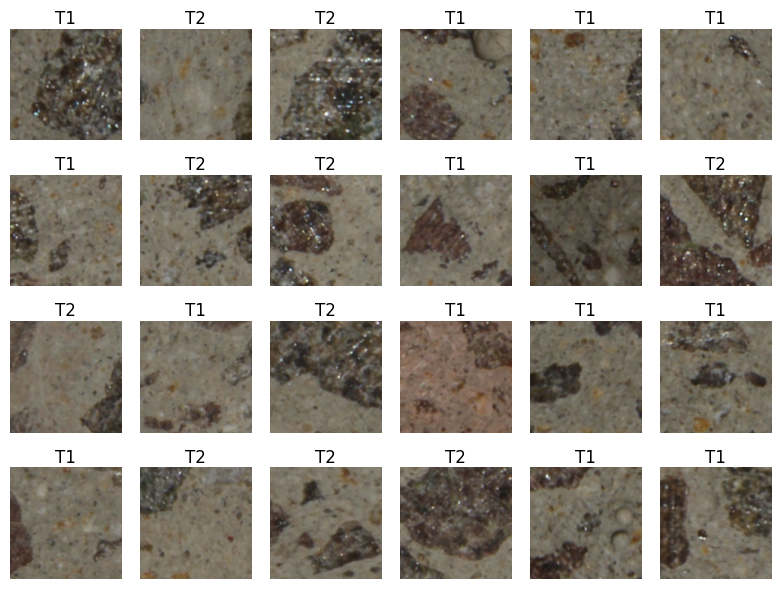

In [10]:
# Display some images from the dataset
num_rows, num_cols = 4, 6
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(8, 6), sharey=True)
fig.subplots_adjust(wspace=0.05, hspace=0.3, bottom=0.05, top=0.95, left=0.05, right=0.95)

# Uncomment the desired line to visualize images from the corresponding set
batch_img = train_it.next() # To view the training set
# batch_img = valid_it.next() # To view the validation set
# batch_img = test_it.next() # To view the test set

for i, (img, label) in enumerate(zip(batch_img[0], batch_img[1])):
  plt.subplot(num_rows, num_cols, i+1)
  plt.imshow(img)
  plt.title(f'{"T1" if label else "T2"}', fontsize=12, pad=4)
  plt.axis('off')
  if i == num_rows*num_cols-1: # Ends when the figure is filled
    break
plt.tight_layout()
plt.savefig('cement_examples.png', dpi=300)
plt.show()

#### Building the architectures of the DNNs


In [11]:
def build_model(model_name='Proposed model', input_shape=(256, 256, 3)):
    """Constructs the specified model.
    
    Args:
    model_name (str): The name of the model to construct.
    input_shape (tuple): The input shape of the images for the model.
    
    Returns:
    model: The constructed model.
    """
    # Construct a baseline model using only basic blocks of Keras
    if model_name == 'Proposed model':
        model = tf.keras.Sequential([
            Input(shape=input_shape), 
            BatchNormalization(),
            Conv2D(32, (3, 3), activation='relu'), 
            MaxPooling2D((2, 2)), 
            BatchNormalization(),
            Conv2D(64, (3, 3), activation='relu'), 
            MaxPooling2D((2, 2)), 
            BatchNormalization(),
            Conv2D(128, (3, 3), activation='relu'), 
            MaxPooling2D((2, 2)), 
            BatchNormalization(),
            Conv2D(128, (3, 3), activation='relu'), 
            MaxPooling2D((2, 2)), 
            BatchNormalization(),
            Flatten(),
            Dense(1024, activation='relu'), 
            Dropout(0.5),
            Dense(512, activation='relu'), 
            Dropout(0.2),
            Dense(1,activation='sigmoid')
        ])

    # Load the pretrained InceptionV3 model
    elif model_name == 'InceptionV3 (Transfer Learning)':
        inception = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet', input_shape=input_shape)
        # Freeze the layers of the base model
        for layer in inception.layers:
            layer.trainable = False
        model = tf.keras.Sequential([
            inception,
            Flatten(),
            Dense(32, activation='relu'), 
            Dropout(0.2),
            Dense(1, activation='sigmoid')
        ])

    # Load the pretrained VGG16 model
    elif model_name == 'VGG16 (Transfer Learning)':
        vgg16 = tf.keras.applications.vgg16.VGG16(include_top=False, weights='imagenet', input_shape=input_shape)
        # Freeze the layers of the base model
        for layer in vgg16.layers:
            layer.trainable = False
        model = tf.keras.Sequential([
            vgg16,
            Flatten(),
            Dense(128, activation='relu'), 
            Dropout(0.2),
            Dense(1, activation='sigmoid')
        ])

    return model


#### Training each model

In [12]:
model_names = ['Proposed model', 'InceptionV3 (Transfer Learning)', 'VGG16 (Transfer Learning)']

# Initialize the DataFrame to store the model metrics
model_details_df = pd.DataFrame(columns=['Model', 'Total_Params', 'Trainable_Params', 'NonTrainable_Params', 'Training_Time'])

for i, model_name in enumerate(model_names):
    start_time = time.time()
    
    # Model creation
    model = build_model(model_name)

    # Model summary
    trainable_params = np.sum([K.count_params(w) for w in model.trainable_weights])
    non_trainable_params = np.sum([K.count_params(w) for w in model.non_trainable_weights])
    
    print(f'{"="*80}')
    print(f'Model Name: {model_name}')
    print(f'Total Parameters: {trainable_params + non_trainable_params:.0f}')
    print(f'Trainable Parameters: {trainable_params:.0f}')
    print(f'Non-Trainable Parameters: {non_trainable_params:.0f}\n')  

    # Compile and train the model
    os.makedirs('checkpoints', exist_ok=True)
    callbacks = [EarlyStopping(monitor='val_loss', mode='auto', verbose=1, patience=10),
                ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, mode='min', min_lr=1e-6),
                CSVLogger(filename=f'checkpoints/training_log_{model_name}.csv', separator=',', append=False),
                ModelCheckpoint(filepath=f'checkpoints/{model_name}.h5', monitor='val_loss', mode='auto', verbose=0, save_best_only=True)]
                
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics='binary_accuracy')
    history = model.fit(train_it, validation_data=valid_it, epochs=100, callbacks=callbacks, verbose=False)
    
    # Compute the training time
    elapsed_time = time.time() - start_time
    hours, remainder = divmod(elapsed_time, 3600)
    minutes, seconds = divmod(remainder, 60)
    formatted_time = f'{hours:.0f}h:{minutes:.0f}m:{seconds:.0f}s'
    
    print(f'Elapsed Training Time: {formatted_time}')

    # Add the model metrics to the DataFrame
    model_details_df.loc[len(model_details_df)] = [model_name, trainable_params + non_trainable_params, trainable_params, non_trainable_params, elapsed_time]

    # Reset the data iterators
    train_it.reset()
    valid_it.reset()

model_details_df.to_csv(f'checkpoints/model_details.csv', index=False)
print(f'{"="*80}')

Model Name: Proposed model
Total Parameters: 26458701
Trainable Parameters: 26457991
Non-Trainable Parameters: 710

Epoch 15: early stopping
Elapsed Training Time: 0h:2m:38s
Model Name: InceptionV3 (Transfer Learning)
Total Parameters: 24162145
Trainable Parameters: 2359361
Non-Trainable Parameters: 21802784

Epoch 18: early stopping
Elapsed Training Time: 0h:3m:12s
Model Name: VGG16 (Transfer Learning)
Total Parameters: 18909249
Trainable Parameters: 4194561
Non-Trainable Parameters: 14714688

Epoch 26: early stopping
Elapsed Training Time: 0h:6m:49s


#### Evaluation of the obtained models

In [13]:
# Define the dataframe header
model_performance_df = pd.DataFrame(columns=['Model', 'Prediction_Time', 'Accuracy', 'Precision', 'Recall', 'F1_score'])

for model_name in model_names:
    # Load the model
    print(f'{"="*80}')
    print(f'Model: {model_name}')
    file = f'./checkpoints/{model_name}.h5'
    model = load_model(file)

    # Perform the prediction on the test set
    tic = time.time()
    y_pred = model.predict(test_it, verbose=False)
    y_pred = (y_pred > .5).astype(int)
    elapsed = time.time() - tic
    y_true = test_it.classes

    # Calculate considered metrics
    test_acc = accuracy_score(y_true=y_true, y_pred=y_pred)
    test_precision = precision_score(y_true=y_true, y_pred=y_pred)
    test_recall = recall_score(y_true=y_true, y_pred=y_pred)
    test_f1 = f1_score(y_true=y_true, y_pred=y_pred)

    # Display the results
    hours, rest = divmod(elapsed,3600)
    minutes, seconds = divmod(rest, 60)
    fmt_time = f'{hours:.0f}h:{minutes:.0f}m:{seconds:.0f}s'
    print(f'Elapsed time (prediction): {fmt_time}')
    print(f'Accuracy (test set): {test_acc:0.2%}')
    print(f'Precision (test set): {test_precision:0.2%}')
    print(f'Recall (test set): {test_recall:0.2%}')
    print(f'F1-score (test set): {test_f1:0.2%}')

    # Add results to the dataframe
    model_performance_df.loc[len(model_performance_df)] = [model_name, elapsed, test_acc, test_precision, test_recall, test_f1]

    # Reset the iterator
    test_it.reset()
print(f'{"="*80}')

# Merge the two dataframes (training and prediction)
combined_df = model_details_df.merge(model_performance_df, on='Model')
del model_details_df, model_performance_df
combined_df.to_csv('results.csv', index=False)

Model: Proposed model
Elapsed time (prediction): 0h:0m:3s
Accuracy (test set): 89.98%
Precision (test set): 88.94%
Recall (test set): 94.74%
F1-score (test set): 91.75%
Model: InceptionV3 (Transfer Learning)
Elapsed time (prediction): 0h:0m:4s
Accuracy (test set): 75.30%
Precision (test set): 86.56%
Recall (test set): 68.65%
F1-score (test set): 76.57%
Model: VGG16 (Transfer Learning)
Elapsed time (prediction): 0h:0m:5s
Accuracy (test set): 75.96%
Precision (test set): 81.86%
Recall (test set): 75.95%
F1-score (test set): 78.79%


#### Plotting the results

In [41]:
# Load the results from the CSV file
df = pd.read_csv('results.csv')

In [42]:
df

,Model,Total_Params,Trainable_Params,NonTrainable_Params,Training_Time,Prediction_Time,Accuracy,Precision,Recall,F1_score
0,Proposed model,26458701,26457991,710,158.119450,2.984730,0.899794,0.889401,0.947405,0.917487
1,InceptionV3 (Transfer Learning),24162145,2359361,21802784,191.597826,4.057375,0.752990,0.865606,0.686536,0.765741
2,VGG16 (Transfer Learning),18909249,4194561,14714688,409.440605,4.860084,0.759588,0.818594,0.759467,0.787923


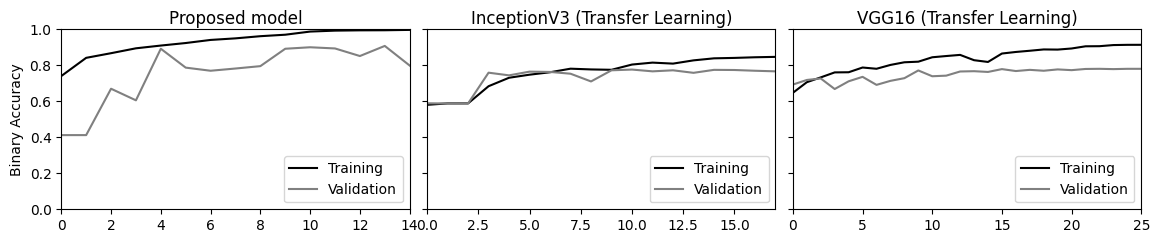

In [43]:
# Plots the training and validation accuracy for each model.
num_rows, num_cols = 1, 3
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(12, 2), sharey=True)
fig.subplots_adjust(wspace=0.05, hspace=0.3, bottom=0.05, top=0.95, left=0.05, right=0.95)

for i, model_name in enumerate(model_names):
    df_temp = pd.read_csv(f'checkpoints/training_log_{model_name}.csv')

    ax = plt.subplot(num_rows, num_cols, i+1)
    ax.plot(df_temp['binary_accuracy'], color='black')
    ax.plot(df_temp['val_binary_accuracy'], color='gray')
    ax.set_title(model_name, fontsize=12, pad=4)
    if i % num_cols == 0:  # Only add y-labels to the first column
        ax.set_ylabel('Binary Accuracy')
    if i // num_cols == 1:  # Only add x-labels to the last row
        ax.set_xlabel('Epoch')
    ax.legend(['Training', 'Validation'], loc='lower right')
    ax.set_xlim((0, len(df_temp['binary_accuracy'])-1))
    ax.set_ylim((0, 1))

plt.savefig('training_evolution.png', dpi=300)

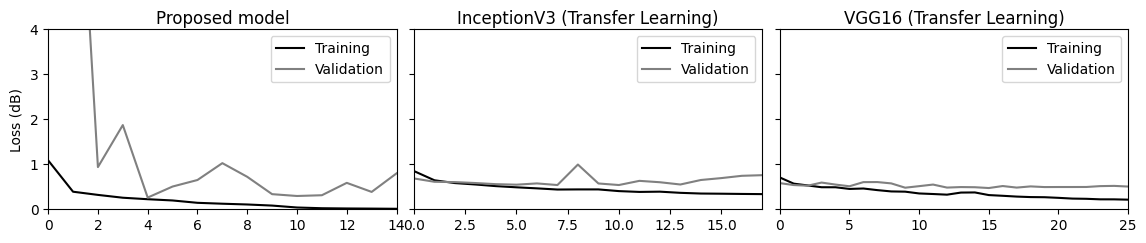

In [44]:
# Plots the training and validation loss for each model.
num_rows, num_cols = 1, 3
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(12, 2), sharey=True)
fig.subplots_adjust(wspace=0.05, hspace=0.3, bottom=0.05, top=0.95, left=0.05, right=0.95)

for i, model_name in enumerate(model_names):
    df_temp = pd.read_csv(f'checkpoints/training_log_{model_name}.csv')

    ax = plt.subplot(num_rows, num_cols, i+1)
    ax.plot(df_temp['loss'], color='black')
    ax.plot(df_temp['val_loss'], color='gray')
    ax.set_title(model_name, fontsize=12, pad=4)
    if i % num_cols == 0:  # Only add y-labels to the first column
        ax.set_ylabel('Loss (dB)')
    if i // num_cols == 1:  # Only add x-labels to the last row
        ax.set_xlabel('Epoch')
    ax.legend(['Training', 'Validation'], loc='upper right')
    ax.set_xlim(0, len(df_temp['loss'])-1)
    ax.set_ylim(0, 4)

plt.savefig('training_evolution_loss.png', dpi=300)

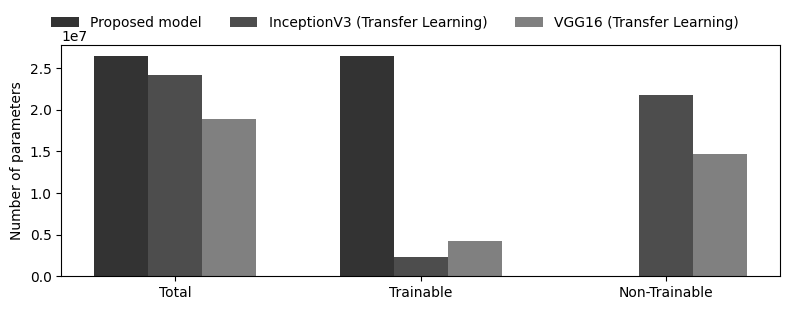

In [57]:
# Results in terms of the number of parameters
columns_of_interest = ['Total_Params', 'Trainable_Params', 'NonTrainable_Params']
data = {}
for model in model_names:
    data[model] = df[df['Model'] == model][columns_of_interest].values

x = np.arange(len(columns_of_interest))  # the label locations
width = 0.22                             # the width of the bars
grayscale_colors = ['0.2', '0.3', '0.5', '0.8']

fig, ax = plt.subplots(figsize=(8, 3))
for i, (attribute, value) in enumerate(data.items()):
    offset = width * i
    rects = ax.bar(x + offset, value.flatten(), width, label=attribute, color=grayscale_colors[i])

ax.set_ylabel('Number of parameters')
ax.set_xticks(x + width)
ax.set_xticklabels(['Total', 'Trainable', 'Non-Trainable'])
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, model_names, loc='upper center', ncol=len(model_names), bbox_to_anchor=(0.5, 1.04), edgecolor='none', facecolor='none')
fig.tight_layout()
fig.savefig('number_of_parameters.png', dpi=300)

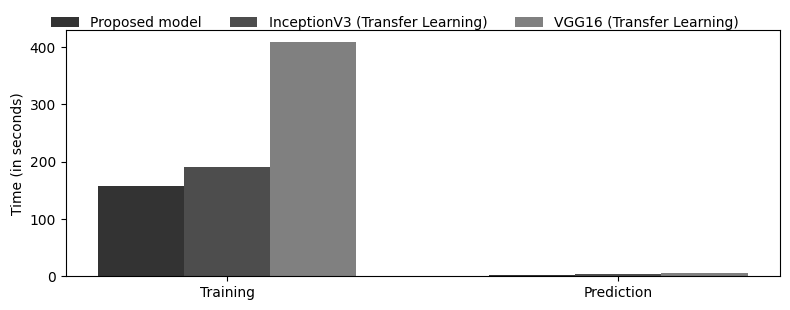

In [55]:
# Results in terms of training and prediction time
columns_of_interest = ['Training_Time', 'Prediction_Time']
data = {}
for model in model_names:
    data[model] = df[df['Model'] == model][columns_of_interest].values

x = np.arange(len(columns_of_interest))  # the label locations
width = 0.22                             # the width of the bars
grayscale_colors = ['0.2', '0.3', '0.5', '0.8']

fig, ax = plt.subplots(figsize=(8, 3))
for i, (attribute, value) in enumerate(data.items()):
    offset = width * i
    rects = ax.bar(x + offset, value.flatten(), width, label=attribute, color=grayscale_colors[i])

ax.set_ylabel('Time (in seconds)')
ax.set_xticks(x + width)
ax.set_xticklabels(['Training', 'Prediction'])
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, model_names, loc='upper center', ncol=len(model_names), bbox_to_anchor=(0.5, 1.04), edgecolor='none', facecolor='none')
fig.tight_layout()
fig.savefig('training_time.png', dpi=300)

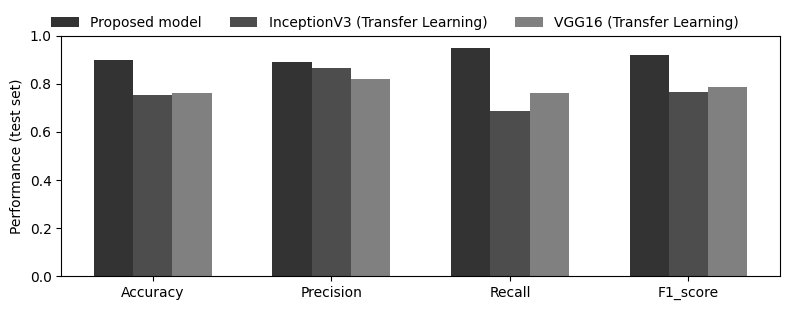

In [59]:
# Results in terms of achieved performance
columns_of_interest = ['Accuracy', 'Precision', 'Recall', 'F1_score']
data = {}
for model in model_names:
    data[model] = df[df['Model'] == model][columns_of_interest].values

x = np.arange(len(columns_of_interest))  # the label locations
width = 0.22                             # the width of the bars
grayscale_colors = ['0.2', '0.3', '0.5', '0.8']

fig, ax = plt.subplots(figsize=(8, 3))
for i, (attribute, value) in enumerate(data.items()):
    offset = width * i
    rects = ax.bar(x + offset, value.flatten(), width, label=attribute, color=grayscale_colors[i])

ax.set_ylabel('Performance (test set)')
ax.set_xticks(x + width)
ax.set_xticklabels(columns_of_interest)
ax.set_ylim((0, 1))
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, model_names, loc='upper center', ncol=len(model_names), bbox_to_anchor=(0.5, 1.04), edgecolor='none', facecolor='none')
fig.tight_layout()
fig.savefig('performance_metrics.png', dpi=300)